In [1]:
library(readxl)

hawaii <- read_excel('../data/hawaii-5-11-22.xls', sheet = 'Complete')

Warning message:
"Expecting logical in W1463 / R1463C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1464 / R1464C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1465 / R1465C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1466 / R1466C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1467 / R1467C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1468 / R1468C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1469 / R1469C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1470 / R1470C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1471 / R1471C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1472 / R1472C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1473 / R1473C23: got 'HISTORICAL [21288]'"
Warning message:
"Expecting logical in W1474 / R1474C23: got 'HISTORICAL [21288]'"
Warn

In [2]:
library(tidyverse)

numerical_data <- hawaii %>% select_if(is.numeric) # Filter out non-numerical fields
primaries <- select(numerical_data,
    "ISLAND",
    "VOLCANO",
    # Major Elements
    "SiO2" = "SIO2(WT%)",
    "TiO2" = "TIO2(WT%)", 
    "Al2O3" = "AL2O3(WT%)", 
    "FeO" = "FeO (Calc)", 
    "CaO" = "CAO(WT%)", 
    "MgO" = "MGO(WT%)", 
    "K2O" = "K2O(WT%)", 
    "Na2O" = "NA2O(WT%)",
    # Minor Elements
    # "P2O5(WT%)",
    # "MNO(WT%)", 
)

# Filter out data with missing values
data <- primaries[complete.cases(primaries), ]
sprintf('Number of samples: %s', nrow(data))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "Number of samples: 10476"

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.92 loaded

Loading required package: cluster



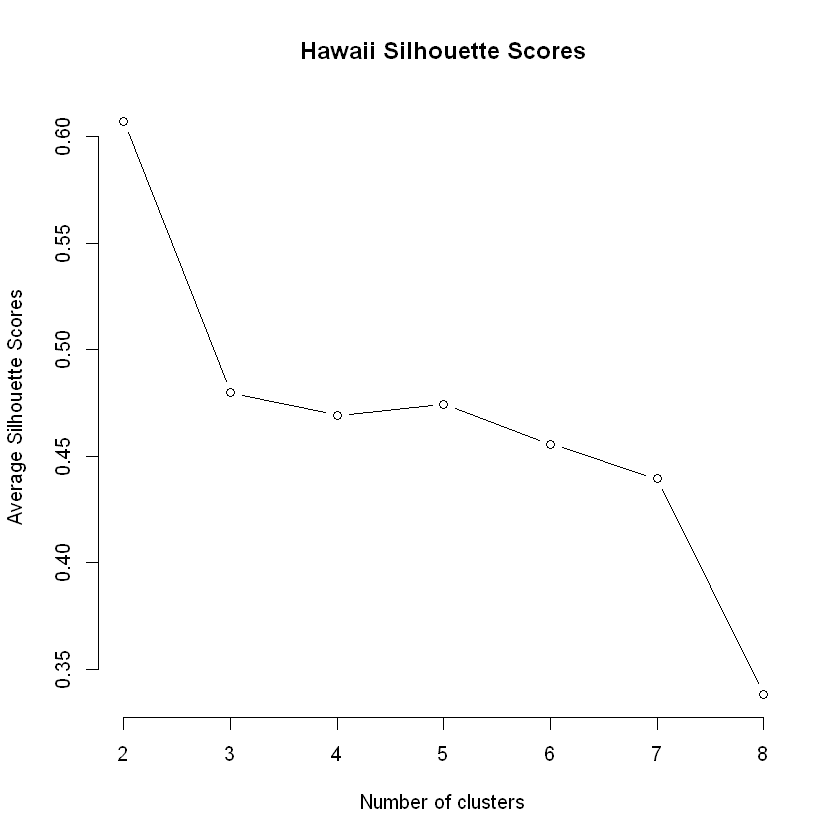

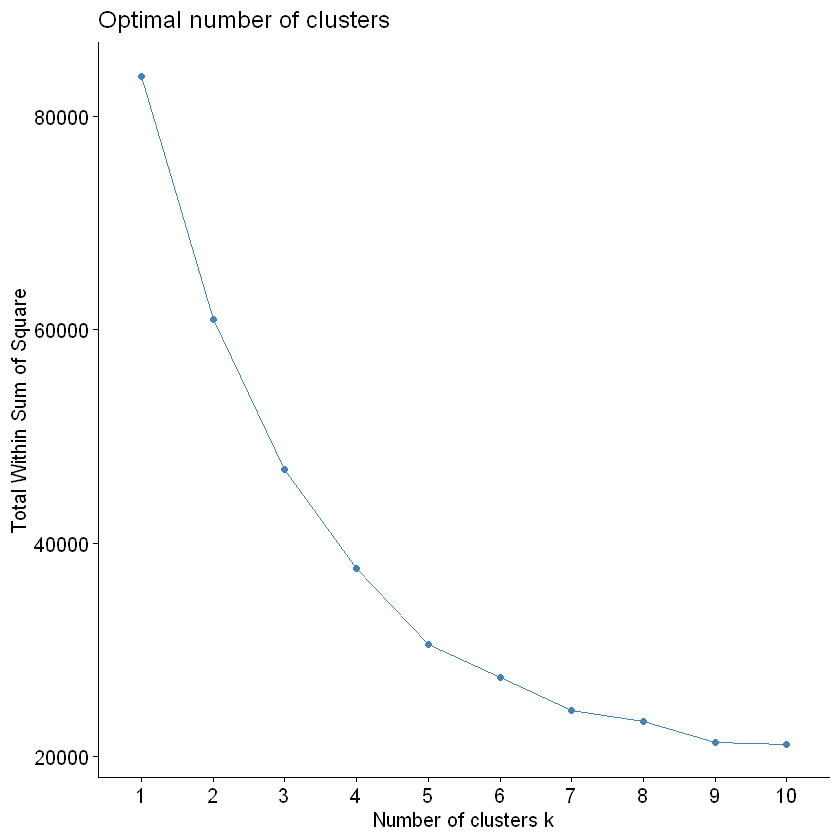

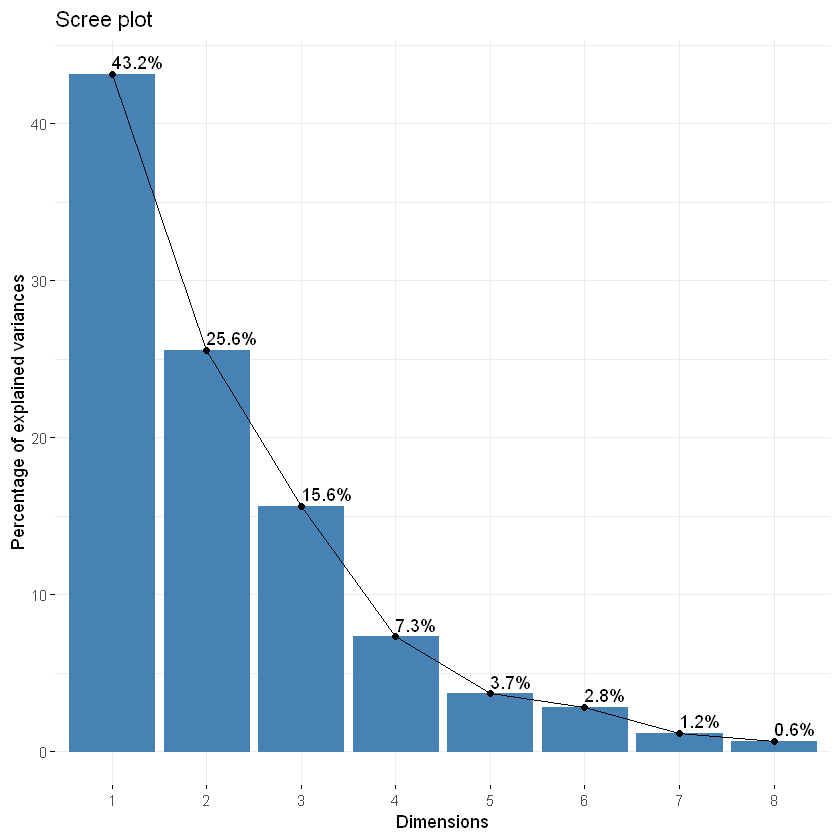

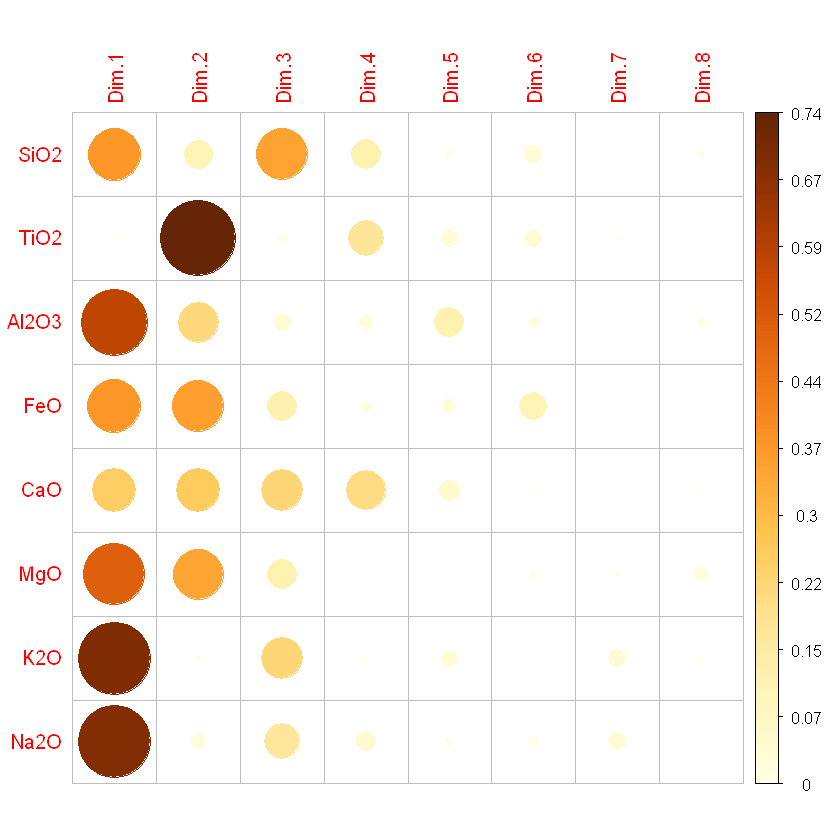

In [3]:
library(factoextra)
library(corrplot)
require(cluster)
set.seed(123)

# c(-1, -2) filters out first two columns (ISLAND, VOLCANO)
pca <- prcomp(data[, c(-1, -2)], scale = TRUE, center = TRUE)
var <- get_pca_var(pca)
ind <- get_pca_ind(pca)

silhouette_score <- function(k){
  km <- kmeans(ind$coord, centers = k, nstart=25)
  ss <- silhouette(km$cluster, dist(ind$coord))
  mean(ss[, 3])
}
k <- 2:8
avg_sil <- sapply(k, silhouette_score)

plot(k, type='b', avg_sil, xlab='Number of clusters', ylab='Average Silhouette Scores', frame=FALSE, main='Hawaii Silhouette Scores')

fviz_nbclust(ind$coord, kmeans, method="wss")
fviz_eig(pca, addlabels = TRUE)
corrplot(var$cos2, is.corr=FALSE)

cluster,SiO2,TiO2,Al2O3,FeO,CaO,MgO,K2O,Na2O
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,49.91912,2.637028,13.77561,11.424514,10.597085,7.299281,0.5441473,2.495990
2,54.24009,2.003535,17.13172,8.376334,5.048751,2.770227,2.7388102,5.436479
3,45.51500,1.962943,10.05487,11.925409,9.103197,16.965137,0.4614238,1.914846


[1] "RMSE: 2.11515210961959"

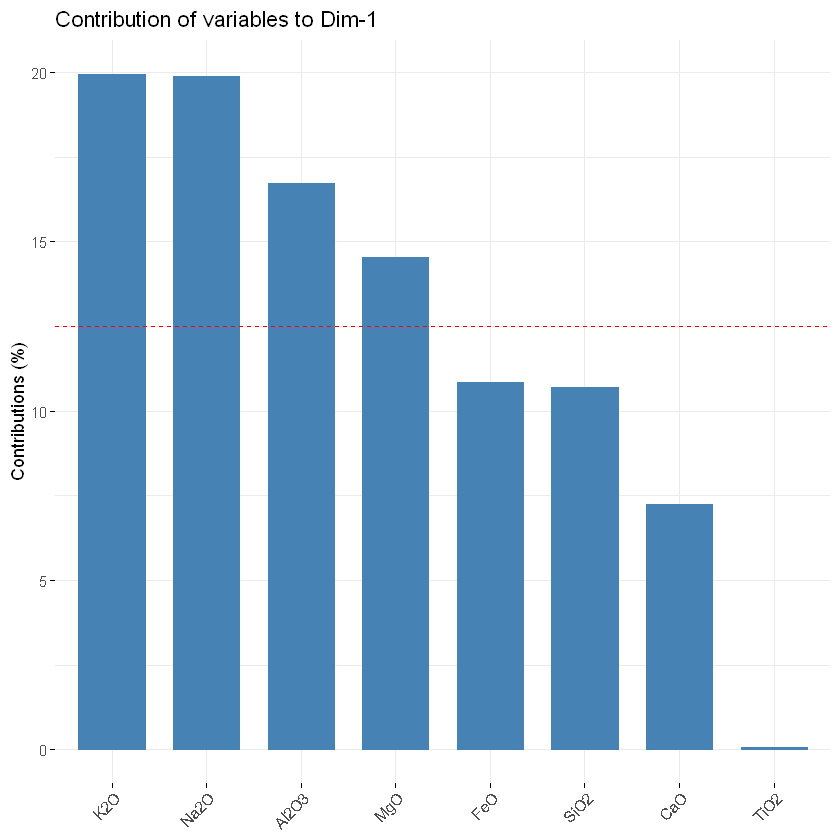

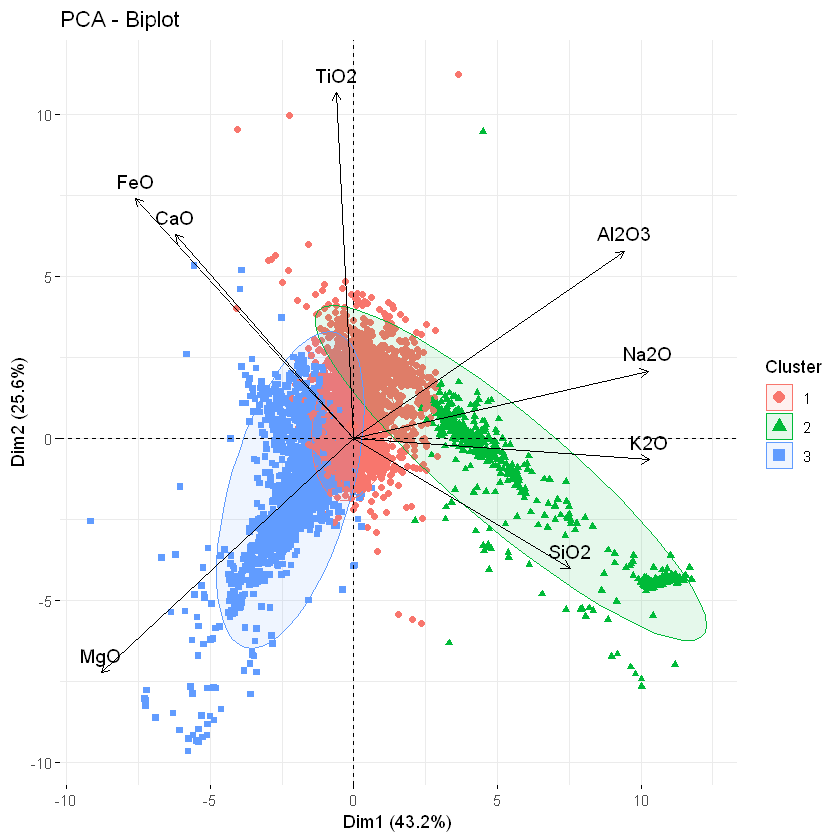

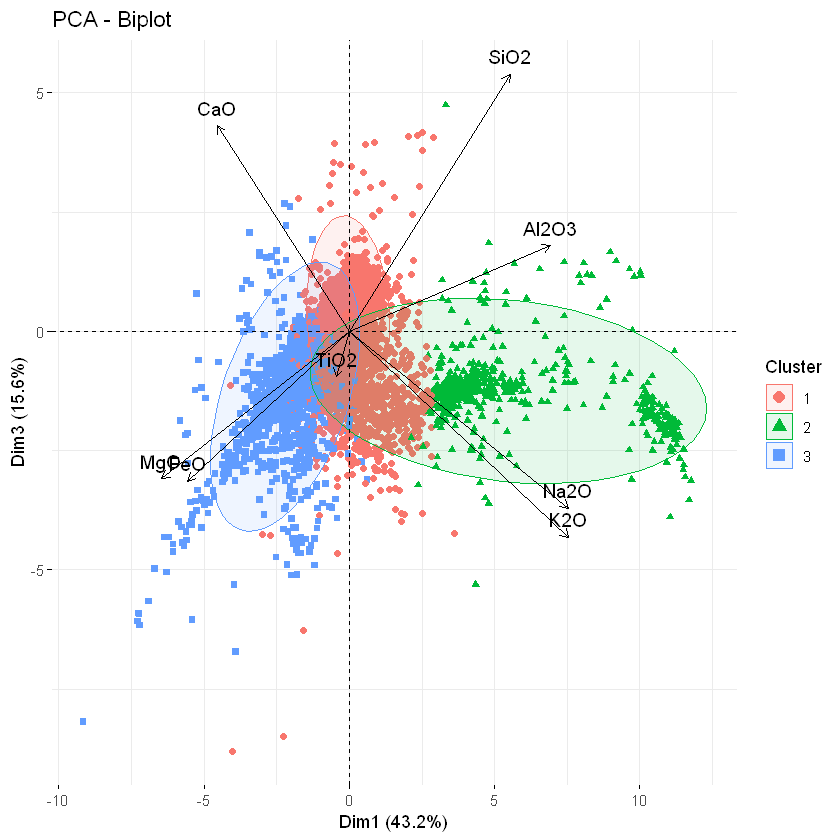

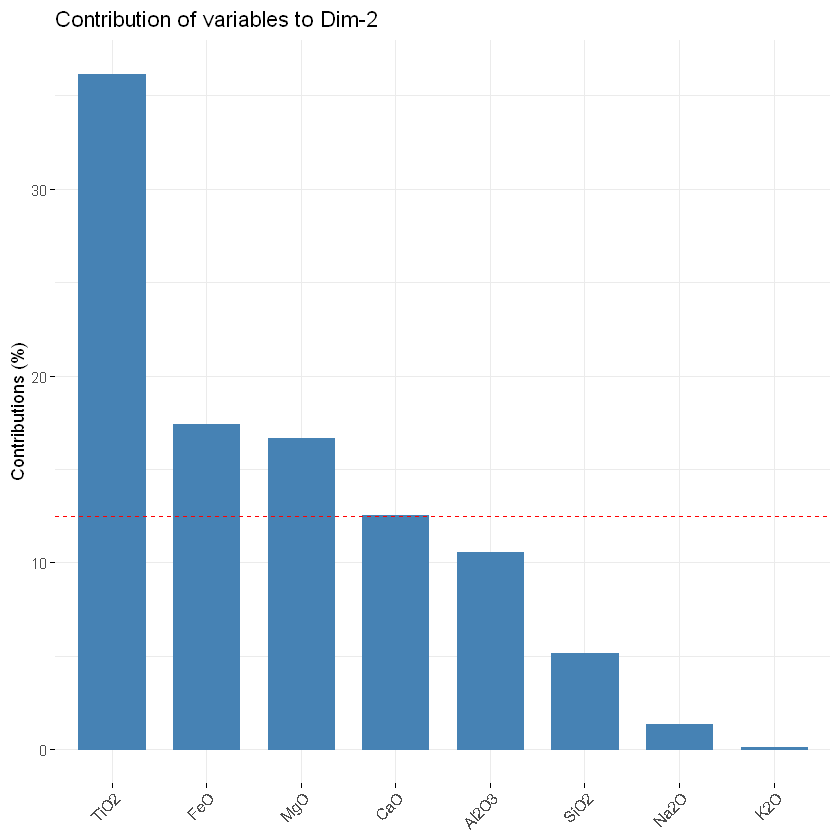

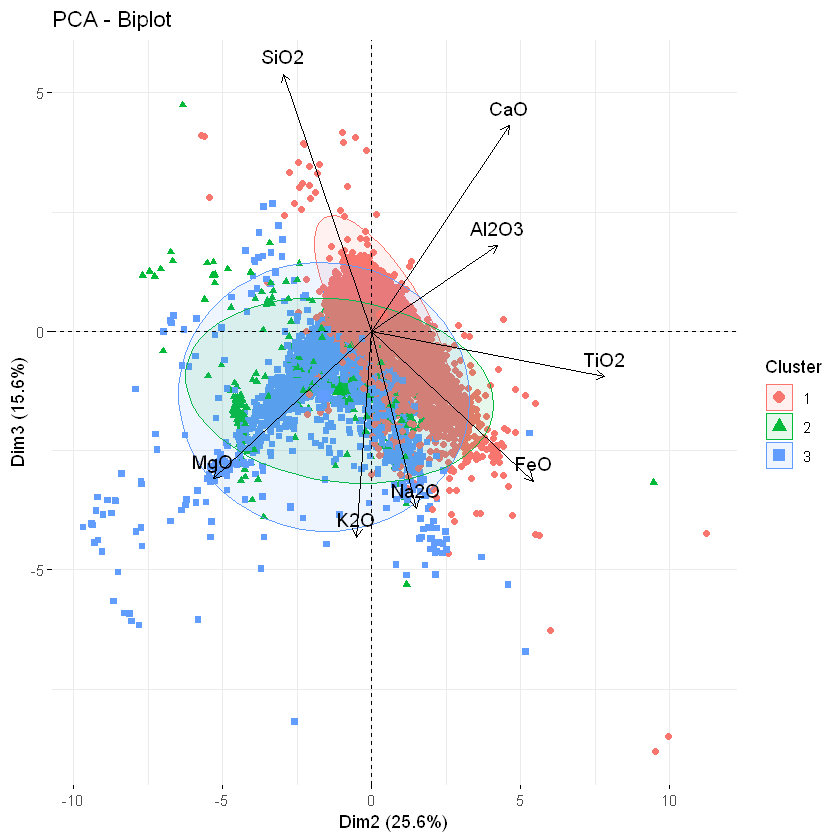

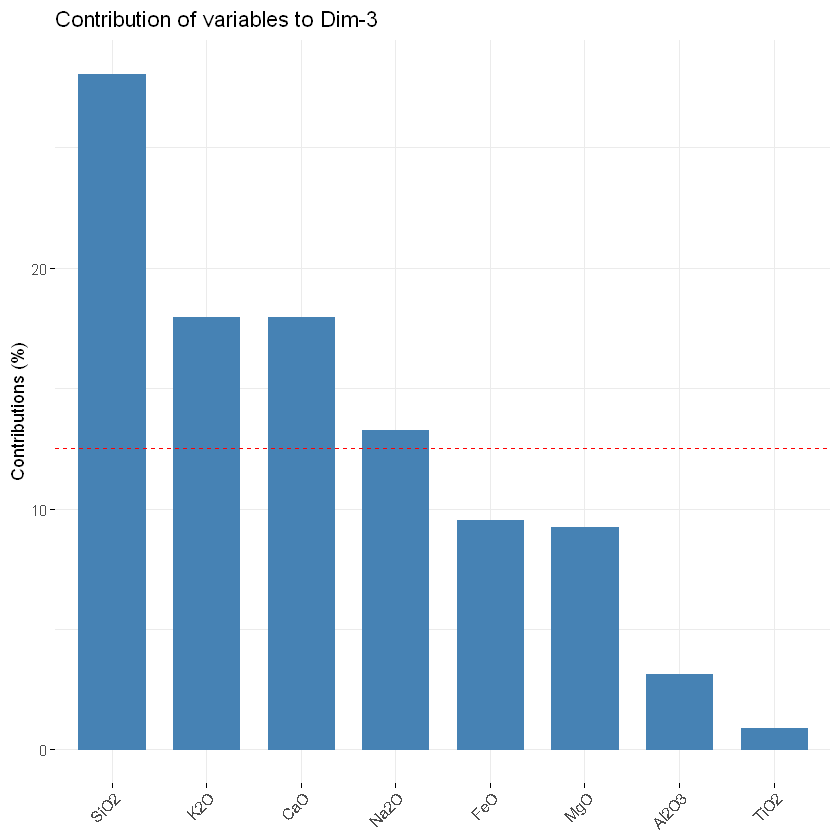

In [10]:
library(stats)

dim <- 3
cluster <- 3

set.seed(123)
km_var <- kmeans(var$coord, centers = cluster, nstart = 25)
km_ind <- kmeans(ind$coord, centers = cluster, nstart = 25)
km_var.grp <- as.factor(km_var$cluster)
km_ind.grp <- as.factor(km_ind$cluster)

# sil <- silhouette(km_ind$cluster, dist(ind$coord))
# fviz_silhouette(sil)

# centroids <- km_ind$centers
# centroids.df <- as.data.frame(centroids)
# row.names(centroids.df) <- paste0('Cluster ', 1:nrow(centroids.df))
# centroids.df

clusters <- data.frame(cluster = km_ind$cluster, data)
averages <- aggregate(clusters[,c(-1, -2, -3)], list(cluster = km_ind$cluster), mean)
averages


rmse_ind <- sqrt(sum(km_ind$withinss) / nrow(ind$coord))
sprintf('RMSE: %s', rmse_ind)

for (i in 1:dim) {

  print(fviz_contrib(pca, choice = "var", axes = i))

  for (k in 1:dim) {
    if (k <= i) next

    print(fviz_pca(pca, 
      col.ind = km_ind.grp,
      col.var = 'black',
      geom.ind = "point", 
      addEllipses = TRUE, 
      legend.title = "Cluster",
      axes = c(i, k),
      # main = c('Hawaii PCA: ', i, ' vs ', k)
    ))

    # print(fviz_pca_var(
    #   pca, 
    #   col.var = 'cos2', 
    #   gradient.cols = c('#00AFBB', '#E7B800', '#FC4E07'), 
    #   repel = TRUE,
    #   axes = c(i, k)
    # ))

    # print(fviz_pca_ind(
    #     pca,
    #     geom.ind = 'point',
    #     col.ind = factor(data$ISLAND),
    #     addEllipses = TRUE,
    #     legend.title = 'Clusters',
    #     axes = c(i, k)
    # ))
  }
}

In [5]:
options(rgl.useNULL = TRUE)
library(rgl)

scores <- as.data.frame(pca$x)

plot3d(scores[, 1:3], col = km_ind.grp, main = "PCA Scores")
text3d(pca$rotation[, 1:3], texts = colnames(data[, c(-1, -2)]), cex = 2, col = "red")

coords <- NULL
for (i in 1:nrow(pca$rotation)) {
  coords <- rbind(coords,
                rbind(c(0, 0, 0),
                    pca$rotation[i, 1:3]
                )
            )
}

lines3d(coords, col='red', lwd=3)

widget <- rglwidget(width=1000, height=1000)
htmlwidgets::saveWidget(widget,
    file = "../plots/hawaii_pca.html", 
    libdir = "../plots/lib",
    selfcontained = TRUE
)

Warning message:
"package 'rgl' was built under R version 4.2.3"


In [6]:
# set.seed(123)
# ind <- get_pca_ind(pca)
# km_var <- kmeans(var$coord, centers = dim, nstart = 25)
# km_ind <- kmeans(ind$coord, centers = dim, nstart = 25)
# km_var.grp <- as.factor(km_var$cluster)
# km_ind.grp <- as.factor(km_ind$cluster)

# fviz_pca(pca, 
#     col.ind = km_ind.grp,
#     col.var = km_var.grp,
#     geom.ind = "point", 
#     addEllipses = TRUE, 
#     legend.title = "Cluster",
# )

# fviz_pca_ind(
#     pca,
#     geom.ind = 'point',
#     col.ind = factor(data$VOLCANO),
#     addEllipses = TRUE,
#     legend.title = 'Clusters'
# )

# # Display KMeans
# fviz_cluster(
#     km_ind, 
#     data = ind$coord,
#     palette = c("#2E9FDF", "#00AFBB", "#E7B800"), 
#     geom = "point",
#     ellipse.type = "convex", 
#     ggtheme = theme_bw(),
#     axes = c(2, 3)
#     )

# fviz_pca_var(
#     pca,
#     col.var = grp,
#     palette = c("#0073C2FF", "#EFC000FF", "#868686FF", "#9AD4D6", "#F2B8B8"),
#     legend.title = 'Cluster'
# )
# fviz_pca(
#     pca,
#     geom.ind = 'point',
#     col.var = grp,
#     col.ind = 'black',
#     palette = c("#0073C2FF", "#EFC000FF", "#868686FF", "#9AD4D6", "#F2B8B8"),
# )
# fviz_cluster(
#     km,
#     data = ind$coord,
#     geom = "point",
#     ellipse.type = "euclid",
# )